In [ ]:
from torchvision import datasets
data_folder = './data' 
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [ ]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/(255*10000) # Done only for us to 
        # understand the impact of Batch normalization
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)
    
def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

def train_batch(x, y, model, optimizer, loss_fn):
    prediction = model(x)[0]
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.inference_mode()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)[0]
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

@torch.inference_mode()
def val_loss(x, y, model, loss_fn):
    model.eval()
    prediction = model(x)[0]
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [ ]:
def train(get_model):
    trn_dl, val_dl = get_data()
    model, loss_fn, optimizer = get_model()
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    for epoch in range(5):
        print(epoch)
        model.train()
        train_epoch_losses, train_epoch_accuracies = [], []
        for ix, batch in enumerate(iter(trn_dl)):
            x, y = batch
            batch_loss = train_batch(x, y, model, optimizer, loss_fn)
            train_epoch_losses.append(batch_loss) 
        train_epoch_loss = np.array(train_epoch_losses).mean()

        for ix, batch in enumerate(iter(trn_dl)):
            x, y = batch
            is_correct = accuracy(x, y, model)
            train_epoch_accuracies.extend(is_correct)
        train_epoch_accuracy = np.mean(train_epoch_accuracies)

        for ix, batch in enumerate(iter(val_dl)):
            x, y = batch
            val_is_correct = accuracy(x, y, model)
            validation_loss = val_loss(x, y, model, loss_fn)
        val_epoch_accuracy = np.mean(val_is_correct)

        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        val_losses.append(validation_loss)
        val_accuracies.append(val_epoch_accuracy)
    
    return model, (train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
def plot(results):
    train_losses, val_losses, train_accuracies, val_accuracies = results
    epochs = np.arange(5)+1
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker
    plt.subplot(211)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid('off')
    plt.show()
    plt.subplot(212)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid('off')
    plt.show()

## Very small input values without batch normalization

0
1
2
3
4


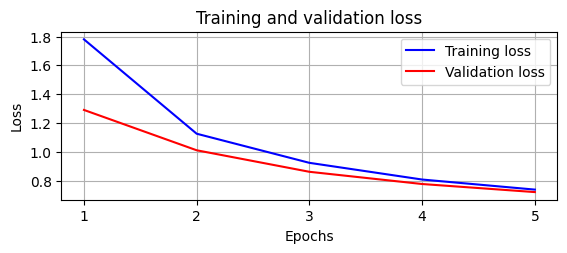

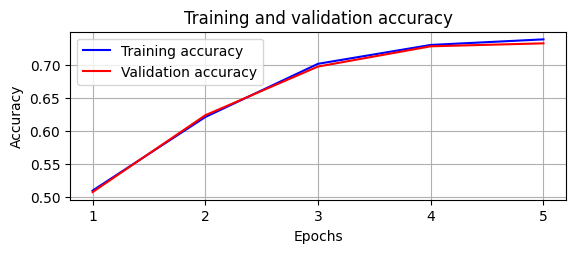

In [ ]:
from torch.optim import Adam
def get_model():
    class neuralnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input_to_hidden_layer = nn.Linear(784,1000)
            self.hidden_layer_activation = nn.ReLU()
            self.hidden_to_output_layer = nn.Linear(1000,10)
        def forward(self, x):
            x = self.input_to_hidden_layer(x)
            x1 = self.hidden_layer_activation(x)
            x2= self.hidden_to_output_layer(x1)
            return x2, x1
    model = neuralnet().to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

model, results = train(get_model)
plot(results)

In [ ]:
model.eval()
trn_dl, val_dl = get_data()
x = next(iter(val_dl))[0]
x.shape

torch.Size([10000, 784])

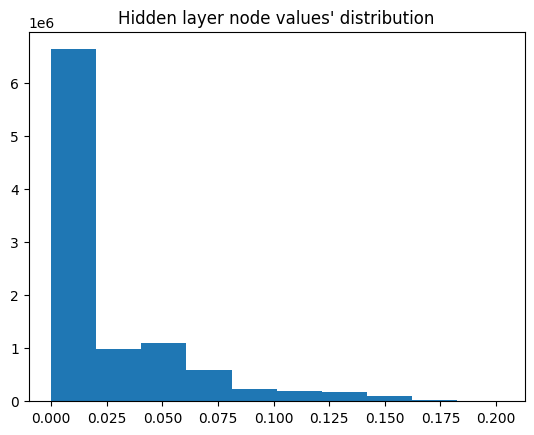

In [ ]:
plt.hist(model(x)[1].cpu().detach().numpy().flatten())
plt.title("Hidden layer node values' distribution");

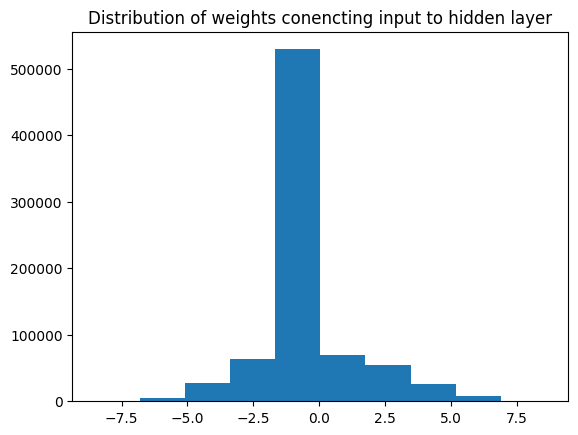

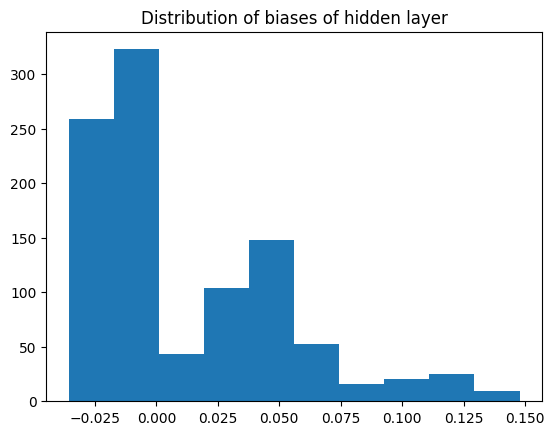

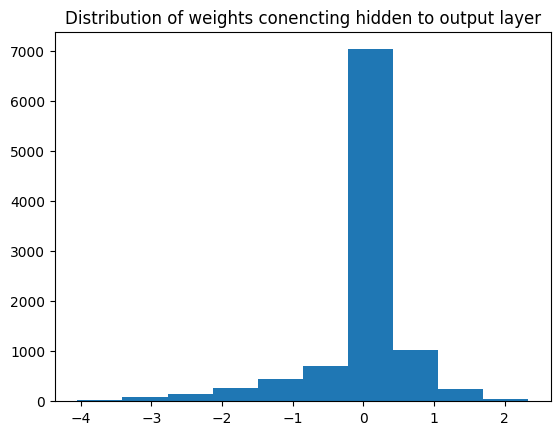

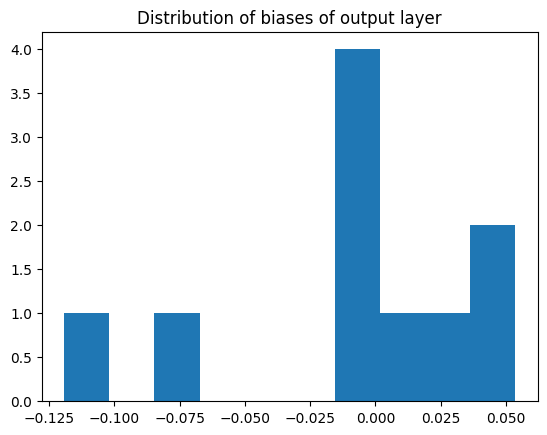

In [ ]:
for ix, par in enumerate(model.parameters()):
  if(ix==0):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of weights conencting input to hidden layer')
      plt.show()
  elif(ix ==1):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of biases of hidden layer')
      plt.show()
  elif(ix==2):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of weights conencting hidden to output layer')
      plt.show()
  elif(ix ==3):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of biases of output layer')
      plt.show()  

## Very small input values with batch normalization

0
1
2
3
4


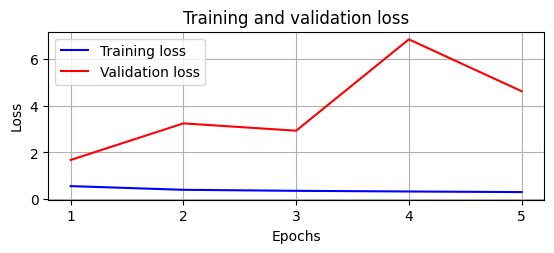

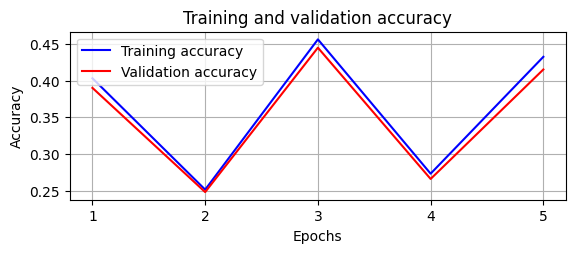

In [ ]:
def get_model():
    class neuralnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input_to_hidden_layer = nn.Linear(784,1000)
            self.batch_norm = nn.BatchNorm1d(1000)
            self.hidden_layer_activation = nn.ReLU()
            self.hidden_to_output_layer = nn.Linear(1000,10)
        def forward(self, x):
            x = self.input_to_hidden_layer(x)
            x0 = self.batch_norm(x)
            x1 = self.hidden_layer_activation(x0)
            x2= self.hidden_to_output_layer(x1)
            return x2, x1
    model = neuralnet().to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

model, results = train(get_model)
plot(results)

In [ ]:
model.eval()
trn_dl, val_dl = get_data()
x = next(iter(val_dl))[0]
x.shape

torch.Size([10000, 784])

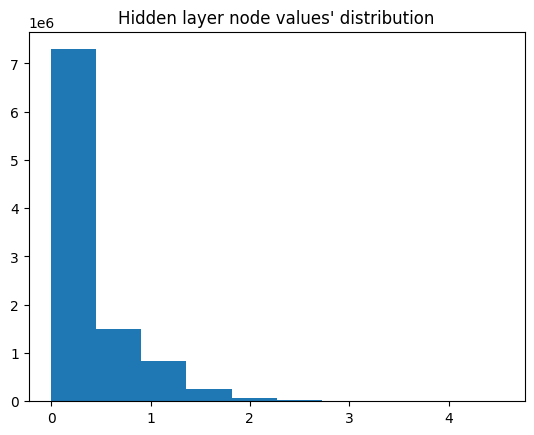

In [ ]:
plt.hist(model(x)[1].cpu().detach().numpy().flatten())
plt.title("Hidden layer node values' distribution");

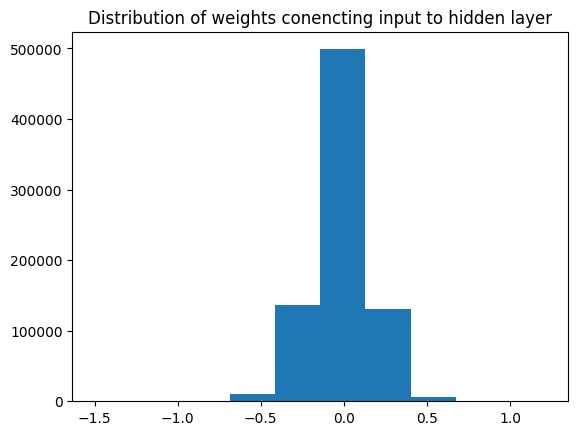

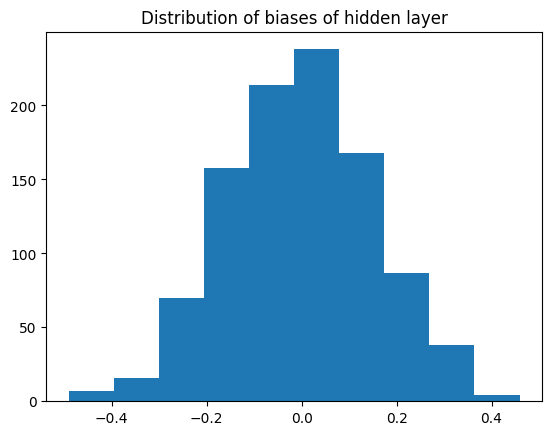

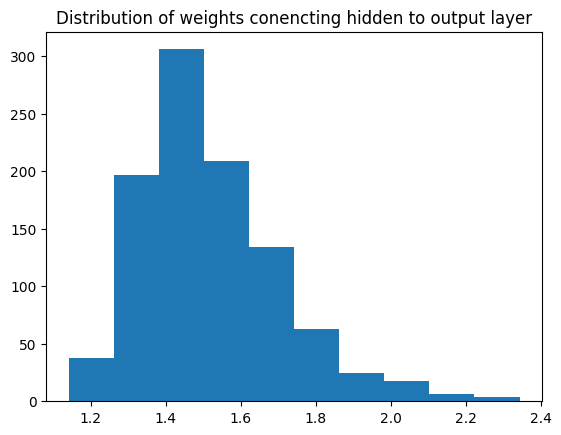

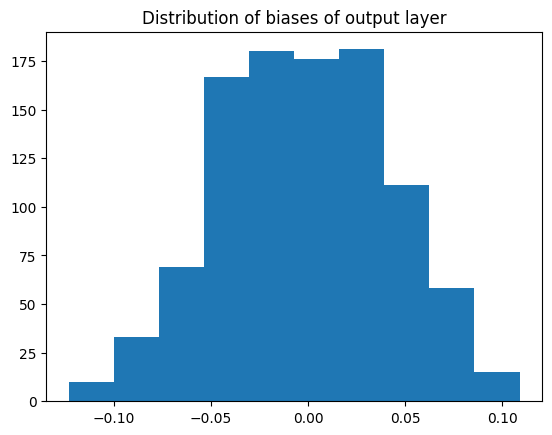

In [ ]:
for ix, par in enumerate(model.parameters()):
  if(ix==0):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of weights conencting input to hidden layer')
      plt.show()
  elif(ix ==1):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of biases of hidden layer')
      plt.show()
  elif(ix==2):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of weights conencting hidden to output layer')
      plt.show()
  elif(ix ==3):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of biases of output layer')
      plt.show()  